In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing useful function
from sklearn.preprocessing import LabelEncoder

# Data scaling
# normalization
from sklearn.preprocessing import MinMaxScaler
# standardization
from sklearn.preprocessing import StandardScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Algorithm
# SVM with linear function
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Functions for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import RocCurveDisplay

In [2]:
df = pd.read_csv('./Titanic_assignment_data_3.csv')
df['Pclass']=df['Pclass'].astype(str)
new_df=df.dropna(axis=0, how='any').copy()
demo_mapping=new_df.copy()

# create dictionary for labels
mapping_Pclass={'3':3,'1':1,'2':2}
mapping_Sex={'male':0,'female':1}
mapping_Embarked={'S':0,'C':1,'Q':2}
mapping_Survived={'no':0,'yes':1}

# using map function
demo_mapping['Pclass']=demo_mapping['Pclass'].map(mapping_Pclass)
demo_mapping['Sex']=demo_mapping['Sex'].map(mapping_Sex)
demo_mapping['Embarked']=demo_mapping['Embarked'].map(mapping_Embarked)
demo_mapping['Survived']=demo_mapping['Survived'].map(mapping_Survived)
dummied_new_df=pd.get_dummies(new_df,columns=['Pclass','Sex','Embarked','Survived'],dtype=int).copy()
dummied_new_df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived_no,Survived_yes
1,28.0,0,0,26.55,1,0,0,0,1,0,0,1,0,1
2,28.0,1,1,14.40,0,0,1,1,0,0,0,1,1,0
3,39.0,0,0,13.00,0,1,0,0,1,0,0,1,1,0
4,22.0,0,0,8.05,0,0,1,0,1,0,0,1,1,0
5,34.0,0,0,13.00,0,1,0,0,1,0,0,1,0,1


In [3]:
#set x (make prediction) with minimax
x=dummied_new_df.drop(['Survived_no','Survived_yes'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scaling=MMscaler.fit_transform(x)
scaled_data=pd.DataFrame(data=scaling)
scaled_data.columns=['Age','SibsSp','Parch','Fare','Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S']
scaled_data.head()

,Age,SibsSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.360000,0.0,0.000000,0.051822,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.360000,0.2,0.166667,0.028107,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.506667,0.0,0.000000,0.025374,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.280000,0.0,0.000000,0.015713,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.440000,0.0,0.000000,0.025374,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
#set y (want to predict)
y=dummied_new_df['Survived_yes'].copy()
y.head()

1    1
2    0
3    0
4    0
5    1
Name: Survived_yes, dtype: int64

In [5]:
# 5.1 Split the data (80% training, 20% testing, lock seed)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

# 設定超參數範圍
C_values = [2 ** i for i in range(-5, 16)]  # C 值範圍 [2^-5, ..., 2^15]
degrees = range(1, 6)  # Degree 範圍 [1, ..., 10]

# 結果儲存矩陣 (每個 random_state 都有一個矩陣)
accuracy_matrices = {}

# 5.2 Manually performing hyperparameter tuning
for random_state in [3, 30, 300]:
    x_train_tuning, x_valid, y_train_tuning, y_valid = train_test_split(
        x_train, y_train, test_size=0.2, random_state=random_state)

    # 建立空矩陣來儲存當前 random_state 的準確度 (len(C_values) x len(degrees))
    acc_matrix = np.zeros((len(C_values), len(degrees)))

    print(f"\nRandom State {random_state}:")
    
    for i, c in enumerate(C_values):
        for j, degree in enumerate(degrees):
            # 初始化模型
            model = SVC(C=c, kernel='poly', degree=degree)
            #model=KNeighborsClassifier(n_neighbors=5) #n_neighbors >= 1
            model.fit(x_train_tuning, y_train_tuning)  # 訓練模型

            # 驗證模型
            prediction = model.predict(x_valid)
            valid_acc = accuracy_score(y_valid, prediction)

            # 儲存準確度至矩陣
            acc_matrix[i, j] = valid_acc * 100  # 轉為百分比格式

    # 四捨五入矩陣結果
    acc_matrix = np.round(acc_matrix, 2)
    accuracy_matrices[random_state] = acc_matrix

    # 打印當前 random_state 的準確度矩陣
    print(f"Accuracy Matrix for Random State {random_state}:")
    print(acc_matrix)

# 計算所有 random_state 準確度矩陣的平均
average_matrix = np.mean(list(accuracy_matrices.values()), axis=0)
average_matrix = np.round(average_matrix, 2)

print("\nAverage Accuracy Matrix Across All Random States:")
print(average_matrix)

# 找出平均準確度矩陣中的最大值及其索引
max_index = np.unravel_index(np.argmax(average_matrix, axis=None), average_matrix.shape)
best_c_index, best_degree_index = max_index

# 取得對應的最佳 C 和 degree 值
best_c = C_values[best_c_index]
best_degree = degrees[best_degree_index]

print(f"\nBest Hyperparameters:")
print(f"C = {best_c}")
print(f"Degree = {best_degree}")


Random State 3:
Accuracy Matrix for Random State 3:
[[57.03 57.03 57.03 57.03 57.03]
 [57.03 57.03 57.03 57.03 57.03]
 [58.59 57.03 57.03 57.03 57.81]
 [58.59 57.03 57.03 57.03 58.59]
 [58.59 57.03 57.03 57.03 58.59]
 [58.59 57.03 57.03 57.81 58.59]
 [57.81 57.03 57.03 58.59 58.59]
 [57.81 57.81 57.81 58.59 59.38]
 [57.81 57.81 57.81 59.38 60.16]
 [58.59 57.81 57.81 60.16 60.16]
 [66.41 60.94 59.38 60.94 60.16]
 [70.31 63.28 61.72 61.72 60.94]
 [71.09 64.06 60.94 62.5  59.38]
 [71.09 71.09 60.94 62.5  60.16]
 [71.09 71.88 62.5  60.94 60.16]
 [71.09 73.44 65.62 61.72 59.38]
 [71.09 75.   65.62 61.72 59.38]
 [71.09 75.78 67.97 63.28 60.16]
 [71.09 75.   72.66 61.72 59.38]
 [71.09 75.78 74.22 63.28 61.72]
 [71.09 75.78 73.44 64.84 63.28]]

Random State 30:
Accuracy Matrix for Random State 30:
[[60.94 60.16 59.38 59.38 58.59]
 [60.94 60.16 59.38 59.38 58.59]
 [62.5  60.16 59.38 59.38 59.38]
 [62.5  60.16 59.38 59.38 59.38]
 [62.5  60.16 59.38 59.38 60.16]
 [62.5  60.16 59.38 59.38 60.16]


Testing ACC: 72.96
Testing f1s: 61.95
Testing pre: 71.43
Testing sen: 54.69
Testing spe: 85.26


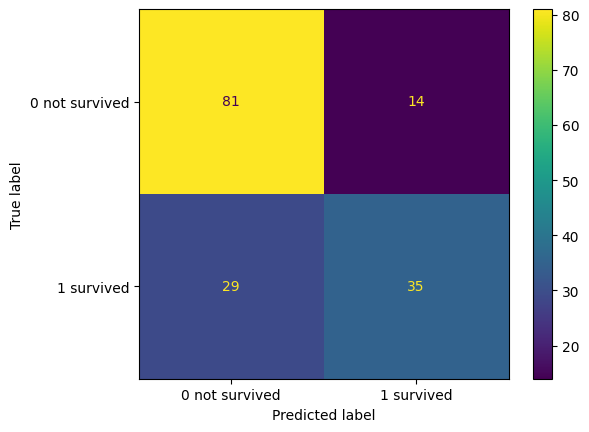

In [6]:
# 6.1 Fit the model with LinearSVC
model=SVC(C=4096,kernel='poly',degree=2)
#model=KNeighborsClassifier(n_neighbors=5)
model.fit(x_train,y_train)
# 7.3 Evaluate with testing data set
final_model_testing_prediction=model.predict(x_test)
final_model_testing_acc=accuracy_score(y_test,final_model_testing_prediction)
final_model_testing_f1s=f1_score(y_test,final_model_testing_prediction,pos_label=1)
final_model_testing_pre=precision_score(y_test,final_model_testing_prediction,pos_label=1)
final_model_testing_sen=sensitivity_score(y_test,final_model_testing_prediction,pos_label=1)
final_model_testing_spe=specificity_score(y_test,final_model_testing_prediction,pos_label=1)
final_model_testing_cm=confusion_matrix(y_test,final_model_testing_prediction)


#print result
print('Testing ACC:',round(final_model_testing_acc*100,2))
print('Testing f1s:',round(final_model_testing_f1s*100,2))
print('Testing pre:',round(final_model_testing_pre*100,2))
print('Testing sen:',round(final_model_testing_sen*100,2))
print('Testing spe:',round(final_model_testing_spe*100,2))
ConfusionMatrixDisplay(final_model_testing_cm,display_labels=["0 not survived","1 survived"]).plot()